<a href="https://colab.research.google.com/github/lungnahahd/Tensorflow_Prac/blob/main/SingleNN_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#################################################################
# Single-Layer NN (Numerical Differentiation)
#################################################################
import numpy as np
import matplotlib.pyplot as plt


def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    
def relu(x):
   return np.maximum(0, x) 

def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad


def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim ==1:
        t=t.reshape(1, t.size)
        y=y.reshape(1, y.size)   
    
    batch_size = y.shape[0]
    delta = 1e-7
    return -np.sum(t*np.log(y+delta)) / batch_size

#----------------------------#
# Class 정의
#----------------------------#
class OneLayerNet:

    def __init__(self, input_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W'] = weight_init_std * np.random.randn(input_size, output_size)
        self.params['b'] = np.zeros(output_size)
        

    def predict(self, x):
        W = self.params['W']
        b = self.params['b']
    
        a = np.dot(x, W) + b
        y = softmax(a)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W'] = numerical_gradient(loss_W, self.params['W'])
        grads['b'] = numerical_gradient(loss_W, self.params['b'])
        
        return grads
        
    def gradient(self, x, t):
        W = self.params['W']
        b = self.params['b']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a = np.dot(x, W) + b
        y = sigmoid(a)
        
        # backward
        dy = (y - t) / batch_num
        dz = sigmoid_grad(a) * dy
        grads['W'] = np.dot(x.T, dz)
        grads['b'] = np.sum(dz, axis=0)   

        return grads
#----------------------------#
# Class 정의 끝
#----------------------------#



In [ ]:
# 데이터 읽기
from mnist import load_mnist 

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=True, one_hot_label=True)
 

print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)



(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


i= 0 train acc, test acc | 0.13571666666666668, 0.1338
i= 600 train acc, test acc | 0.8532166666666666, 0.861
i= 1200 train acc, test acc | 0.8696666666666667, 0.8783
i= 1800 train acc, test acc | 0.8787333333333334, 0.8855
i= 2400 train acc, test acc | 0.8825833333333334, 0.8919
i= 3000 train acc, test acc | 0.88625, 0.8931
i= 3600 train acc, test acc | 0.8895166666666666, 0.8964
i= 4200 train acc, test acc | 0.8910833333333333, 0.8986
i= 4800 train acc, test acc | 0.8931166666666667, 0.9017
i= 5400 train acc, test acc | 0.8944833333333333, 0.9017
i= 6000 train acc, test acc | 0.8954166666666666, 0.9029
i= 6600 train acc, test acc | 0.8967333333333334, 0.9041
i= 7200 train acc, test acc | 0.8977, 0.9053
i= 7800 train acc, test acc | 0.8986166666666666, 0.907
i= 8400 train acc, test acc | 0.8998166666666667, 0.9081
i= 9000 train acc, test acc | 0.9003, 0.9082
i= 9600 train acc, test acc | 0.9013, 0.9084


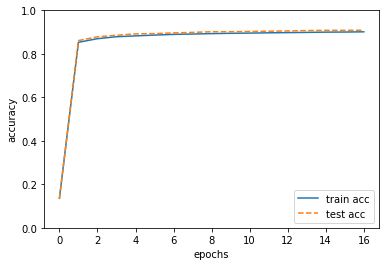

In [ ]:
network = OneLayerNet(input_size=784, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    noise = np.random.rand(100).astype(np.float32)
    np.zeros_like(noise)
    
     
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W', 'b'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("i=", i, "train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [ ]:

from PIL import Image

def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    pil_img.show()
    
img = x_train[1]
label = t_train[1]

print(img.shape)
img = img.reshape(28, 28)
print(label)
print(img.shape)

img_show(img)

(784,)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(28, 28)


In [ ]:
#
# Sample Test
#
id_test = 15

img=x_test[id_test]
label = t_test[id_test]
print(label)
out = network.predict(img)
out

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


array([3.90084229e-03, 3.69723159e-04, 1.26685686e-03, 2.80835669e-02,
       2.46291897e-03, 9.49765390e-01, 3.40712931e-04, 1.32817359e-03,
       1.24723438e-02, 9.47136788e-06])